Let's perform a full likelihood fit using toy data.

In [6]:
import numpy as np
import jax.numpy as jnp
from jax import jit
import pandas as pd

df_WW = pd.read_hdf('dataWW_wPred.h5', key='dataset')

df_WW_Sig = df_WW[df_WW.label==1]
df_WW_Bkg = df_WW[df_WW.label==0]

In [7]:
import numpy as np

obs_sig = df_WW_Sig.BDT_pred.ravel()
obs_bkg = df_WW_Bkg.BDT_pred.ravel()

xmin = np.amin(obs_bkg)
xmax = np.amax(obs_sig)

bins = np.linspace(xmin, xmax, num=10)

hist_sig, _ = np.histogram(obs_sig, bins, weights=df_WW_Sig.mcWeight)
hist_bkg, _ = np.histogram(obs_bkg, bins, weights=df_WW_Bkg.mcWeight)

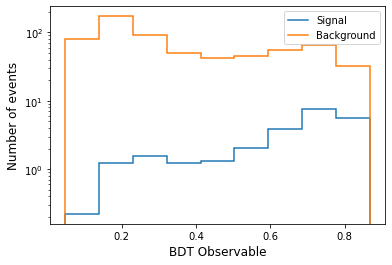

In [8]:
import mplhep as hep
from matplotlib import pyplot as plt

hep.histplot(hist_sig, bins, label='Signal')
hep.histplot(hist_bkg, bins, label='Background')

plt.xlabel('BDT Observable', size=12)
plt.ylabel('Number of events', size=12)
plt.legend(loc='upper right')
plt.yscale('log')

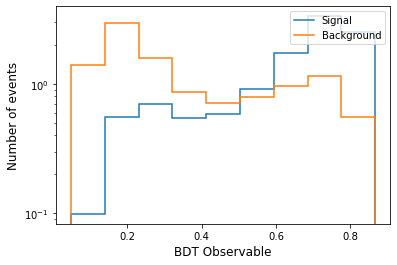

In [9]:
import mplhep as hep
from matplotlib import pyplot as plt

hep.histplot(hist_sig, bins, label='Signal', density=1)
hep.histplot(hist_bkg, bins, label='Background', density=1)

plt.xlabel('BDT Observable', size=12)
plt.ylabel('Number of events', size=12)
plt.legend(loc='upper right')
plt.yscale('log')

In [10]:
# Build test statistic

# Calculate the overall yield based on the value of signal strength mu

def sigma(mu, hist_sig, hist_bkg):
    
    sigma_mu_binned = mu*hist_sig+hist_bkg  
                        
    return sigma_mu_binned


In [11]:
print(sigma(1.0, hist_sig, hist_bkg))

[ 81.44700434 173.27195032  94.42159246  51.71184839  42.99699869
  47.76060627  59.97951239  73.95018394  37.93186379]


In [13]:
# The so called Asimov expected events (the exact number of events we would expect to observe if our hypothesis is correct)
N_obs_Asimov = hist_sig + hist_bkg
print(N_obs_Asimov)


[ 81.44700434 173.27195032  94.42159246  51.71184839  42.99699869
  47.76060627  59.97951239  73.95018394  37.93186379]


In [14]:
# Define the test statistic function

def NLL(mu, hist_sig, hist_bkg, N_obs_Asimov):
    
    sigma_mu = sigma(mu, hist_sig, hist_bkg)

    llr = jnp.array([-2*N_obs_Asimov*jnp.log(sigma_mu)+2*sigma_mu]).sum()
    
    return llr


<br>

<br>

Minuit expects the arguments of the function to be the set of parameters that are to be fitted. 

In our current function, we also have the constants as additional parameters.

<br>

In [15]:
# Let us define a basic wrapper function for Minuit

def NLL_minuit(mu):
    
    return NLL(mu, hist_sig, hist_bkg, N_obs_Asimov)

In [18]:
from iminuit import Minuit
from jax import grad

# Call the Minuit instance using the NLL_minuit test statistic function
# The second argument is the array of starting values from which Minuit can start fitting the curve
# Optionally, we can pass the exact gradient function, calculated using JAX, that Minuit can then use for a fit
m1 = Minuit(jit(NLL_minuit), jnp.array([1.0]), grad=jit(grad(NLL_minuit)), name=['mu'])


m1.errordef = Minuit.LEAST_SQUARES
m1.precision = 1e-7
m1.strategy = 2
m1.migrad()
m1.minos()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -4539                      │              Nfcn = 21               │
│ EDM = 3.62e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu   │    1.0    │    0.7    │    -0.7    │    0.7     │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┐
│          │          mu           │
├──────────┼───────────┬───────────┤
│  Error   │   -0.7    │    0.7    │
│  Valid   │   True    │   True    │
│ At Limit │   False   │   False   │
│ Max FCN  │   False   │   False   │
│ New Min  │   False   │   False   │
└──────────┴───────────┴───────────┘
┌────┬───────┐
│    │    mu │
├────┼───────┤
│ mu │ 0.485 │
└────┴───────┘

In [19]:
# We can get the best-fit values straight from iMinuit!

print("Maximum Likelihood Estimate for POI : "+str(np.array(m1.values)))
print(f"Error estimates for POI : "+str(np.array(m1.errors)))

Maximum Likelihood Estimate for POI : [1.]
Error estimates for POI : [0.69642724]


In [20]:
%%timeit

m1 = Minuit(NLL_minuit, jnp.array([1.0]), grad=grad(NLL_minuit))
m1.errordef = Minuit.LEAST_SQUARES
m1.strategy = 2
m1.migrad()

135 ms ± 4.62 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
%%timeit

m1 = Minuit(jit(NLL_minuit), jnp.array([1.0]), grad=jit(grad(NLL_minuit)))
m1.errordef = Minuit.LEAST_SQUARES
m1.strategy = 2
m1.migrad()

5.31 ms ± 94 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Text(0.5, 1.0, '')

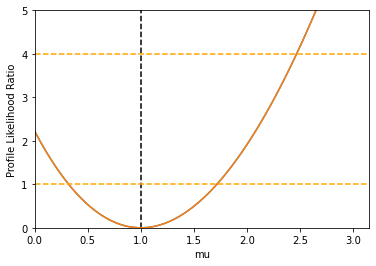

In [26]:
bins, values = m1.draw_mnprofile('mu', bound=(0.0,3.0), size=100, subtract_min=True, band=False)

plt.plot(bins, values)
plt.axis(ymax=5.0, ymin=0.0, xmin=0.0)
plt.ylabel('Profile Likelihood Ratio')
plt.axhline(y = 1.0, color = 'orange', linestyle = '--')
plt.axhline(y = 4.0, color = 'orange', linestyle = '--')
plt.title('')

In [30]:
NP_size = 10

param_array = [0.0] * (NP_size+1)

param_array[0] = 1.0 
param_array = jnp.array(param_array, dtype='float32')

arr_ratio_up_sig = jnp.array(jnp.abs(np.random.normal(1.0, 0.1, NP_size)))
arr_ratio_down_sig = jnp.array(2.0 - arr_ratio_up_sig)

arr_ratio_up_bkg = jnp.array(jnp.abs(np.random.normal(1.0, 0.1, NP_size)))
arr_ratio_down_bkg = jnp.array(2.0 - arr_ratio_up_bkg)


In [32]:
print(hist_sig)
print(arr_ratio_up_sig)

[0.22189089 1.24963431 1.56840724 1.22182351 1.32643705 2.04516869
 3.89587086 7.51318547 5.67517499]
[0.7567248 1.0078123 1.0793102 1.0715469 1.0422426 1.3467959 0.9803385
 0.9702419 1.114458  1.0537115]


<br>

<br>

$$\frac{\nu_{i}(\alpha_m)}{\nu_{i}} = \begin{cases}\displaystyle\left(\frac{\nu_{i}^+}{\nu_{i}}\right)^{\alpha_m} & \alpha_m > 1\\\displaystyle
		1+\sum_{i=1}^6 a_i\alpha^i_m & -1 \leq \alpha_m \leq 1\\\displaystyle
		\left(\frac{\nu_{i}^-}{\nu_{i}}\right)^{-\alpha_m} & \alpha_m < -1\end{cases}$$

<br>

<br>

In [24]:

#from jax.config import config
#config.update("jax_debug_nans", True)

@jit
def poly_interp(tuple_input):
    
    alpha, varUp, varDown, varNom = tuple_input
    
    pow_up = jnp.divide(varUp,varNom)
    pow_down = jnp.divide(varDown,varNom)
    logHi = jnp.log(jnp.clip(pow_up,1e-7,None))
    logLo = jnp.log(jnp.clip(pow_down,1e-7,None))
    logHi = jnp.log(pow_up)
    logLo = jnp.log(pow_down)
    pow_up_log = jnp.multiply(pow_up,logHi)
    pow_down_log = -jnp.multiply(pow_down,logLo)
    pow_up_log2 = jnp.multiply(pow_up_log,logHi)
    pow_down_log2 = -jnp.multiply(pow_down_log,logLo)
    
    S0 = (pow_up+pow_down)/2.0
    A0 = (pow_up-pow_down)/2.0
    S1 = (pow_up_log+pow_down_log)/2.0
    A1 = (pow_up_log-pow_down_log)/2.0
    S2 = (pow_up_log2+pow_down_log2)/2.0
    A2 = (pow_up_log2-pow_down_log2)/2.0
 
    a1 = (15*A0-7*S1+A2)/8.0
    a2 = (-24+24*S0-9*A1+S2)/8.0
    a3 = (-5*A0+5*S1-A2)/4.0
    a4 = (12-12*S0+7*A1-S2)/4.0
    a5 = (3*A0-3*S1+A2)/8.0
    a6 = (-8+8*S0-5*A1+S2)/8.0

    return 1.0 + alpha * (a1 + alpha * ( a2 + alpha * ( a3 + alpha * ( a4 + alpha * ( a5 + alpha * a6 ) ) ) ) )
    

@jit
def exp_interp(tuple_input):
    
    alpha, varUp, varDown, varNom = tuple_input
    
    return jnp.where(alpha>1.0, (varUp/varNom)**alpha, (varDown/varNom)**(-alpha))


@jit
def lin_interp(alpha, varUp, varDown):
    
    return jnp.where(alpha>=0.0, (alpha*(varUp-1)), (alpha*(varDown-1)))

@jit
def sigma(mu, hist_sig, hist_bkg, fact_sig, fact_big):
    
    sigma_mu_binned = mu*hist_sig*fact_sig + hist_bkg*fact_big
                        
    return sigma_mu_binned


In [37]:
print(param_array)
print(arr_ratio_up_sig)

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.82835484 0.88638234 1.1989461  0.9574244  0.796599   1.237041
 0.27420697 1.6234648  0.772342   1.3397752 ]


In [59]:
import jax

@jit
def NLL(param_array, hist_sig, hist_bkg, N_obs_Asimov, arr_ratio_up_sig, arr_ratio_down_sig, arr_ratio_up_bkg, arr_ratio_down_bkg):
    
    print(param_array)
    mu = param_array[0]
    print(mu)
    print(hist_sig)
        
    def syst_update(n, carry):
        
        print(carry)
        fact_sig, fact_bkg = carry

        fact_sig *= jax.lax.cond(jnp.abs(param_array[n])<=1.0, poly_interp, exp_interp, (param_array[n], arr_ratio_up_sig[n-1], arr_ratio_down_sig[n-1], 1.0))

        fact_bkg *= jax.lax.cond(jnp.abs(param_array[n])<=1.0, poly_interp, exp_interp, (param_array[n], arr_ratio_up_bkg[n-1], arr_ratio_down_bkg[n-1], 1.0))
        
        return fact_sig, fact_bkg
        
    fact_sig, fact_bkg = jax.lax.fori_loop(1, len(param_array), syst_update, jnp.ones(2))
    
    sigma_mu = sigma(mu, hist_sig, hist_bkg, fact_sig, fact_big)

    llr = jnp.array([-2*N_obs_Asimov*jnp.log(sigma_mu)+2*sigma_mu]).sum()    
    
    return llr
    

In [60]:
print(jnp.ones(2))

[1. 1.]


In [61]:
print(NLL(param_array, hist_sig, hist_bkg, N_obs_Asimov, 
          arr_ratio_up_sig, arr_ratio_down_sig, arr_ratio_up_bkg, arr_ratio_down_bkg))

Traced<ShapedArray(float32[11])>with<DynamicJaxprTrace(level=1/0)>
Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>
Traced<ShapedArray(int32[6])>with<DynamicJaxprTrace(level=1/0)>
Traced<ShapedArray(float32[2])>with<DynamicJaxprTrace(level=2/0)>


TypeError: scan carry output and input must have same type structure, got PyTreeDef((*, (*, *))) and PyTreeDef((*, *)).

In [58]:
@jit
def NLL_minuit(mu):
    
    return NLL(mu, hist_sig, hist_bkg, N_obs_Asimov)

In [56]:
from iminuit import Minuit
from jax import grad

m1 = Minuit(jit(NLL_minuit), param_array, grad=jit(grad(NLL_minuit)))
m1.errordef = Minuit.LEAST_SQUARES
#m1.precision = 1e-7
m1.strategy = 2
m1.migrad()
m1.minos()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()